In [1]:
import pandas as pd
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split
import time
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
import joblib
import shap
import matplotlib.pyplot as plt

In [2]:
city = 'CityA'

data_path = '../../data/output/' + city + '/normalized_data_X.csv'
y_path = '../../data/output/' + city + '/y.csv'

data = pd.read_csv(data_path)
y = pd.read_csv(y_path)
print(data.shape)
print(y.shape)
data.head()

(1432633, 420)
(1432633, 1)


,route,tripNum,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,gpsLon,...,alertTypeSB_ACCIDENT,alertTypeSB_CHIT_CHAT,alertTypeSB_HAZARD,alertTypeSB_JAM,alertTypeSB_NORMAL,alertTypeSB_POLICE,alertTypeSB_ROAD_CLOSED,jamBlockTypeSB_-,jamBlockTypeSB_NORMAL,jamBlockTypeSB_ROAD_CLOSED_EVENT
0,0.118068,0.066667,0.085019,0.264600,0.496150,0.057584,0.0,0.000000,0.266155,0.496047,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.118068,0.066667,0.085026,0.270218,0.501802,0.064231,0.0,0.000148,0.271812,0.501642,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.118068,0.066667,0.085033,0.273653,0.505296,0.068301,0.0,0.000000,0.275187,0.505192,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.118068,0.066667,0.085039,0.277433,0.509404,0.072900,0.0,0.000149,0.280622,0.510132,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.118068,0.066667,0.085053,0.280050,0.513166,0.077983,0.0,0.000155,0.281878,0.513178,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [35]:
# same data of rvm test
# for the experiment with the rvm
data_size = 5000

data = data[0:data_size]
y = y[0:data_size]
print(data.shape)
print(y.shape)

(5000, 420)
(5000, 1)


In [3]:
# Making training and test data: 80% Training, 20% Test
random.seed(15) #to get always the same set
train_X, test_X, train_Y, test_Y = train_test_split(data, y, test_size=0.20, random_state=7)

In [4]:
# Reading same test files to be used in the same experiments
test_path = '../../data/output/' + city

test_X = pd.read_csv(test_path + '/test_X.csv')
test_Y = pd.read_csv(test_path + '/test_Y.csv')

## XGBoost

In [5]:
# City A
# GridSearch to find best parameter values using the smaller dataset (5%)

random.seed(42)

start = time.time()

parameters = {
    'n_estimators': [25, 50, 75, 100, 125, 150],
    'max_depth': [5, 25, 50, 75, 100],
    'learning_rate': [0.01, 0.05, 0.1, 0.5]
    #'min_child_weight': [ 1, 3, 5, 7],
    #'gamma': [0.0, 0.1, 0.2 , 0.3],
    #'colsample_bytree': [0.3, 0.5, 0.7, 0.9]
}

xgb = XGBClassifier()

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=parameters,
    scoring=make_scorer(f1_score),
    n_jobs=-1
)

grid_search.fit(data, y)

end = time.time()
print("Execution time: " + str((end - start)/60) + " min")
print(grid_search.best_estimator_)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Execution time: 258.5916388551394 min
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=25, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [5]:
# XGBoost after GridSearch

# values of the gridSearch (previous step)
best_estimator = 25
best_depth = 5
best_learning_rate = 0.01

start = time.time()

xgb = XGBClassifier(
 learning_rate = best_learning_rate,
 n_estimators = best_estimator, 
 max_depth = best_depth,
 min_child_weight=1,
 gamma = 0,
 subsample = 0.8,
 colsample_bytree = 0.8,
 objective = 'binary:logistic',
 nthread = -1,
 scale_pos_weight = 1,
 seed = 23)

xgb.fit(train_X, train_Y)

joblib.dump(xgb, 'Models/Saved_' + city + '_XGBoost_GRID_all_data.pkl')

end = time.time()
print("Execution time: " + str((end - start)/60) + " min")

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Execution time: 0.7975698153177897 min


In [4]:
random.seed(42)

start = time.time()

xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=120, 
 max_depth=50,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=-1,
 scale_pos_weight=1,
 seed=23)

xgb.fit(train_X, train_Y)

end = time.time()
print("Execution time: " + str((end - start)/60) + " min")

/home/veruskabs05/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[11:17:27] WARNING: /workspace/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
Execution time: 601.7539962967237 min


In [10]:
print("Execution time: " + str((end - start)/60) + " min") #all - Curitiba

Execution time: 1399.5225323120753 min


In [5]:
# Saving a pickle file for the mode
# joblib.dump(xgb, 'Saved_XGB_BB_class.pkl')
#joblib.dump(xgb, 'Saved_Curitiba_XGB_BB_class.pkl')
#joblib.dump(xgb, 'Saved_Recife_XGB_75p_BB_class.pkl')
#joblib.dump(xgb, 'Saved_Recife_XGB_52p_BB_class.pkl')
#joblib.dump(xgb, 'Saved_Recife_XGB_25p_BB_class.pkl')
#joblib.dump(xgb, 'Saved_Curitiba_XGB_BB_class.pkl')
joblib.dump(xgb, 'Saved_Curitiba_XGB_BB_gps_gtfs_class.pkl')

['Saved_Curitiba_XGB_BB_gps_gtfs_class.pkl']

### F-beta test

In [5]:
#--- 
# The F-beta score is the weighted harmonic mean of precision and recall, reaching its optimal value at 1 and its 
# worst value at 0.

# The beta parameter determines the weight of recall in the combined score. beta < 1 lends more weight to 
# precision, while beta > 1 favors recall (beta -> 0 considers only precision, beta -> +inf only recall).

from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=5)

parameters = {
    'n_estimators': [120],
    'max_depth': [50],
    'learning_rate': [0.1],
    'min_child_weight': [1],
    'gamma': [0.0],
    'colsample_bytree': [0.8]
}

start = time.time()

xgb = XGBClassifier()
grid = GridSearchCV(xgb, param_grid=parameters, scoring=ftwo_scorer)
grid.fit(train_X, train_Y)

pred_array = grid.predict(test_X)

output_path = '../../data/output/' + city

xgb_pred_pd = pd.DataFrame(pred_array)
xgb_pred_pd.to_csv(output_path + "/xgb_pred_beta5.csv", index=False)

end = time.time()
print("Execution time: " + str((end - start)/60) + " min")


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Execution time: 1008.4226399024327 min


### SHAP values

#### City A

Execution time: 9309.373270686467 min


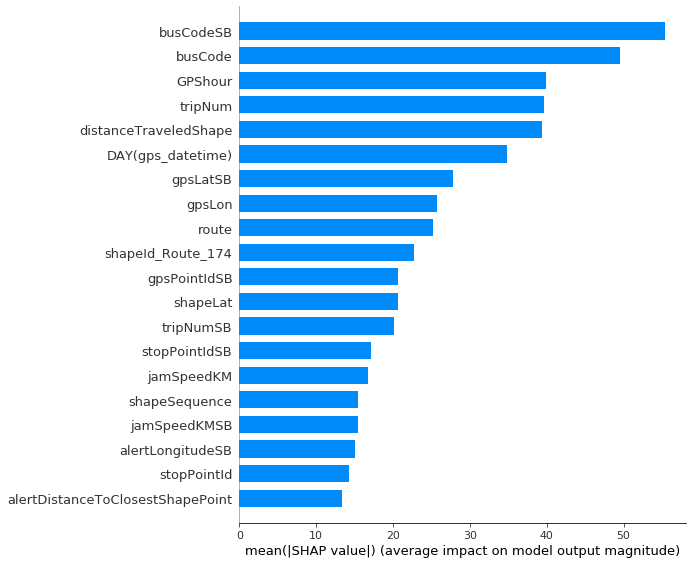

In [8]:
# explain the model's predictions using SHAP
# 100%

xgb = joblib.load('Models/Saved_' + city + '_XGB_BB_class.pkl')

start = time.time()

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(train_X, check_additivity=False)

end = time.time()
print("Execution time: " + str((end - start)/60) + " min")

shap.summary_plot(shap_values, train_X, plot_type="bar", show=False)
plt.savefig('xgboost_shap_values.pdf', bbox_inches = "tight")

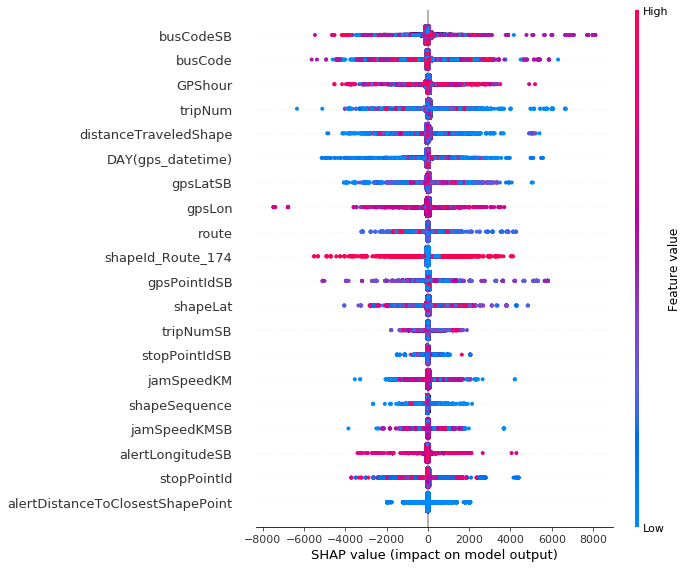

In [16]:
shap.summary_plot(shap_values, train_X, show=False)
plt.savefig('xgboost_shap_values_plot_all_data.pdf', bbox_inches = "tight")

Execution time: 143.0848174770673 min


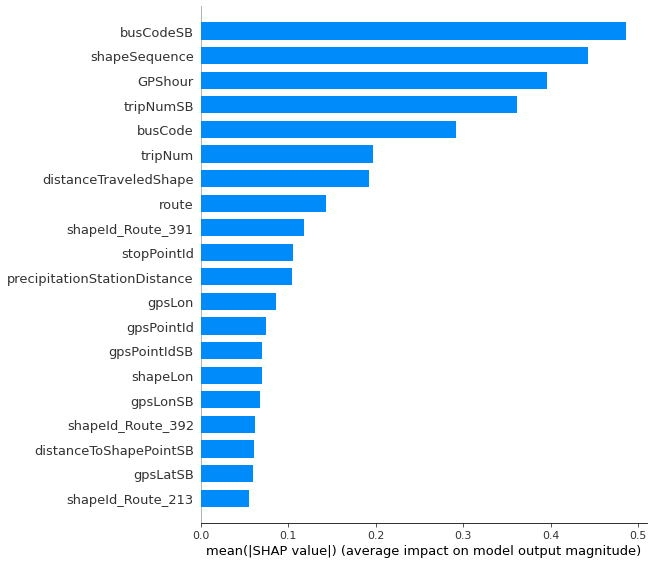

In [7]:
# explain the model's predictions using SHAP
# 5%
start = time.time()

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(train_X, check_additivity=False)

end = time.time()
print("Execution time: " + str((end - start)/60) + " min")

fig = shap.summary_plot(shap_values, train_X, plot_type="bar", show=False)
#plt.savefig('xgboost_shap_values.pdf', bbox_inches = "tight")

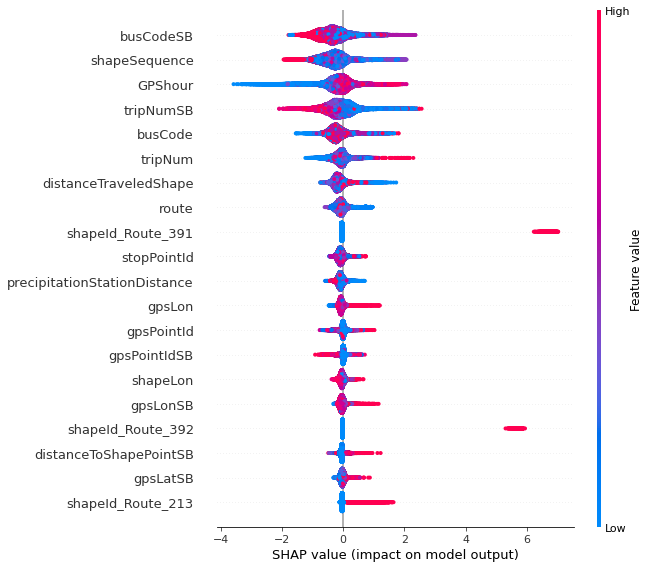

In [8]:
shap.summary_plot(shap_values, train_X, show=False)
plt.savefig('xgboost_shap_values_plot.pdf', bbox_inches = "tight")

### Evaluating Model

In [6]:
def get_quality(bb_pred):
    #headway
    #alpha = y.headwayThreshold[test_Y.index]
    
    #bb_pred = np.less_equal(pred, alpha)
    #bb_label = np.less_equal(test_Y, alpha)
    
    #rmse = np.sqrt(mean_squared_error(test_Y, pred))
    #print('RMSE: ' + str(rmse))
    
    bb_label = test_Y
    
    # Bus Bunching
    print("Accuracy: " + str(accuracy_score(bb_label, bb_pred)))
    print("Precision: " + str(precision_score(bb_label, bb_pred)))
    print("Recall: " + str(recall_score(bb_label, bb_pred)))
    print("F-measure: " + str(f1_score(bb_label, bb_pred)))

In [7]:
pred_array = xgb.predict(test_X)
pred_array

array([0., 0., 0., ..., 0., 0., 0.])

#### Curitiba

In [9]:
get_quality(pred_array) #gps+gtfs+waze

Accuracy: 0.9795945308512984
Precision: 0.8752690683976039
Recall: 0.7458374212629214
F-measure: 0.8053862334751033


In [10]:
get_quality(pred_array) #gps+gtfs+weather

Accuracy: 0.9802690785099419
Precision: 0.8779095663075933
Recall: 0.7567006498030684
F-measure: 0.8128111922289764


In [8]:
get_quality(pred_array) #gps+gtfs

Accuracy: 0.9803036913372948
Precision: 0.87703893712181
Recall: 0.7584069160659187
F-measure: 0.8134202600175378


#### City A

In [8]:
get_quality(pred_array) #100% GRID

Accuracy: 0.8689093872479732
Precision: 0.8713450292397661
Recall: 0.030899240480078805
F-measure: 0.05968206283640005


In [10]:
get_quality(pred_array) #100% beta2

Accuracy: 0.9509051502999717
Precision: 0.906225139220366
Recall: 0.7086865230577806
F-measure: 0.7953742090333842


In [7]:
get_quality(pred_array) #100% beta5

Accuracy: 0.9509051502999717
Precision: 0.906225139220366
Recall: 0.7086865230577806
F-measure: 0.7953742090333842


In [11]:
get_quality(pred_array) #30000

Accuracy: 0.9736666666666667
Precision: 0.9414634146341463
Recall: 0.7423076923076923
F-measure: 0.8301075268817205


In [10]:
get_quality(pred_array) #25000

Accuracy: 0.972
Precision: 0.9295302013422819
Recall: 0.6994949494949495
F-measure: 0.7982708933717579


In [18]:
get_quality(pred_array) #20000

Accuracy: 0.967
Precision: 0.8613861386138614
Recall: 0.6258992805755396
F-measure: 0.7249999999999999


In [26]:
get_quality(pred_array) #15000

Accuracy: 0.973
Precision: 0.9272727272727272
Recall: 0.5828571428571429
F-measure: 0.7157894736842105


In [33]:
get_quality(pred_array) #10000

Accuracy: 0.982
Precision: 0.896551724137931
Recall: 0.4406779661016949
F-measure: 0.5909090909090909


In [41]:
get_quality(pred_array) #5000

Accuracy: 0.991
Precision: 0.6
Recall: 0.3
F-measure: 0.4


In [ ]:
# Bus Bunching
accuracy = accuracy_score(test_Y, pred_array)
precision = precision_score(test_Y, pred_array)
recall = recall_score(test_Y, pred_array)
f_measure = f1_score(test_Y, pred_array)

In [11]:
# all data - Curitiba
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F-measure: " + str(f_measure))

Accuracy: 0.9795285249944861
Precision: 0.8751984757065735
Recall: 0.7445577215657837
F-measure: 0.8046097111247695


In [10]:
# gps+gtfs - Recife
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F-measure: " + str(f_measure))

Accuracy: 0.9510098524746359
Precision: 0.9056198347107438
Recall: 0.7101381652279856
F-measure: 0.7960538742063434


In [10]:
# gps+gtfs+weather - Recife
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F-measure: " + str(f_measure))

Accuracy: 0.9508178984877516
Precision: 0.9070656691604323
Recall: 0.7071571143427431
F-measure: 0.794732855561382


In [13]:
# gps+gtfs+waze - Recife
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F-measure: " + str(f_measure))

Accuracy: 0.9502734471794979
Precision: 0.9060382522781134
Recall: 0.7036316976436737
F-measure: 0.7921092564491654


In [7]:
# 5p - Recife
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F-measure: " + str(f_measure))

Accuracy: 0.8688675063781075
Precision: 0.585432266848196
Recall: 0.08917230474116701
F-measure: 0.15477020673520347


In [11]:
# 25p - Recife
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F-measure: " + str(f_measure))

Accuracy: 0.8899196236305829
Precision: 0.767772872583346
Recall: 0.26147704590818366
F-measure: 0.39009958425988595


In [15]:
# 52p - Recife
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F-measure: " + str(f_measure))

Accuracy: 0.9328265748079587
Precision: 0.8834404506863445
Recall: 0.5772351401093916
F-measure: 0.6982424784033363


In [19]:
# 75p - Recife
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F-measure: " + str(f_measure))

Accuracy: 0.9560913980183369
Precision: 0.944923666735127
Recall: 0.7155818233662545
F-measure: 0.8144148928323819


In [18]:
# 1000, to compare with rvm
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F-measure: " + str(f_measure))

Accuracy: 0.975
Precision: 1.0
Recall: 0.5454545454545454
F-measure: 0.7058823529411764


In [9]:
# 3000, to compare with rvm
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F-measure: " + str(f_measure))

Accuracy: 0.9733333333333334
Precision: 0.9634146341463414
Recall: 0.8586956521739131
F-measure: 0.9080459770114943


In [9]:
# all data - Recife
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F-measure: " + str(f_measure))

Accuracy: 0.9502525067445651
Precision: 0.9080629466832199
Recall: 0.7015320009331986
F-measure: 0.7915472360339281


In [9]:
# all data - Recife
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F-measure: " + str(f_measure))

Accuracy: 0.9502525067445651
Precision: 0.9080629466832199
Recall: 0.7015320009331986
F-measure: 0.7915472360339281
